# Minor Flood Frequency

```{glue:figure} fig-threshold_counts_enso
:name: fig-threshold_counts_enso
:align: left
:scale: 50%
```


In this notebook we will plot two indicators concerning flooding at the Malakal tide gauge, after first taking a general look at the type of data we are able to plot from the [UH Sea Level Center](https://uhslc.soest.hawaii.edu/stations/?stn=007#levels). These indicators are based on a 'flooding' threshold, using [relative sea level](https://tidesandcurrents.noaa.gov/sltrends/faq.html). 

<!-- Download Files: -->
<!-- [Map](../output/SL_FloodFrequency_map.png) |
[Time Series Plot](../output/SL_FloodFrequency_threshold_counts_days.png) |
[Table](../output/SL_FloodFrequency_percent_change.csv) -->



## Setup

We first need to import the necessary libraries, access the data, and make a quick plot to ensure we will be analyzing the right thing.

### Import necessary libraries.

In [33]:
# Standard libraries
import os
import os.path as op
import datetime
from pathlib import Path
import sys

# Data manipulation libraries
import numpy as np
import pandas as pd
import xarray as xr

# Data analysis libraries
import scipy.stats as stats

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import Normalize

from urllib.request import urlretrieve #used for downloading files

# Miscellaneous
from myst_nb import glue  # used for figure numbering when exporting to LaTeX

sys.path.append("../../../functions")
from data_downloaders import download_oni_index, download_uhslc_data
from sea_level_func import detect_enso_events



Next, we'll establish our directory for saving and reading data, and our output files.
```{caution}
You will need to change the variable for "output_dir" to your own output path to save figures and tables to a place of your choosing.
```

In [34]:
data_dir = Path('../../../data')
path_figs = "../../../matrix_cc/figures"
data_dir = Path(data_dir,'sea_level')

#CHANGE THIS TO YOUR PATH!!
# output_dir = Path('/Users/laurac/Library/Mobile Documents/com~apple~CloudDocs/Projects/CC_indicators/CC_indicators/data/')  # EDIT THIS TO YOUR PATH
output_dir = Path('/Users/jfiedler/Projects/CC_indicators/output/')  # EDIT THIS TO YOUR PATH
# Create the output directory if it does not exist
output_dir.mkdir(exist_ok=True)
data_dir.mkdir(exist_ok=True)

 ##  Retrieve the Tide Station(s) Data Set(s)

Next, we'll access data from the UHSLC. The Malakal tide gauge has the UHSLC ID: 7. We will import the netcdf file into our current data directory, and take a peek at the dataset. We will also import the datums for this location. 

In [35]:
uhslc_id = 7
# download the hourly data
rsl = download_uhslc_data(data_dir, uhslc_id,'hourly')      
rsl       

<xarray.Dataset> Size: 6MB
Dimensions:               (record_id: 1, time: 494889)
Coordinates:
  * time                  (time) datetime64[ns] 4MB 1969-05-18T15:00:00 ... 2...
  * record_id             (record_id) int64 8B 7
Data variables:
    sea_level             (record_id, time) float32 2MB ...
    lat                   (record_id) float32 4B ...
    lon                   (record_id) float32 4B ...
    station_name          (record_id) <U7 28B 'Malakal'
    station_country       (record_id) <U5 20B 'Palau'
    station_country_code  (record_id) float32 4B ...
    uhslc_id              (record_id) int16 2B ...
    gloss_id              (record_id) float32 4B ...
    ssc_id                (record_id) |S4 4B ...
    last_rq_date          (record_id) datetime64[ns] 8B ...
Attributes:
    title:                  UHSLC Fast Delivery Tide Gauge Data (hourly)
    ncei_template_version:  NCEI_NetCDF_TimeSeries_Orthogonal_Template_v2.0
    featureType:            timeSeries
    Conventions:            CF-1.6, ACDD-1.3
    date_created:           2025-12-18T14:36:30Z
    publisher_name:         University of Hawaii Sea Level Center (UHSLC)
    publisher_email:        philiprt@hawaii.edu, markm@soest.hawaii.edu
    publisher_url:          http://uhslc.soest.hawaii.edu
    summary:                The UHSLC assembles and distributes the Fast Deli...
    processing_level:       Fast Delivery (FD) data undergo a level 1 quality...
    acknowledgment:         The UHSLC Fast Delivery database is supported by ...

and we'll save a few variables that will come up later for report generation.

In [36]:
station = rsl['station_name'].item()
country = rsl['station_country'].item()
startDateTime = str(rsl.time.values[0])[:10]
endDateTime = str(rsl.time.values[-1])[:10]
station_name = station + ', ' + country

glue("station",station,display=False)
glue("country",country, display=False)
glue("startDateTime",startDateTime, display=False)
glue("endDateTime",endDateTime, display=False)


### Set the Datum to MHHW

```{margin} A Note on Datums

The sea level variable in the netcdf file is sea level **relative to the station datum**. For more information on the data processing of this gauge, see the [station metdata](https://uhslc.soest.hawaii.edu/rqds/pacific/doc/qa007b.dmt). 

```

In this example, we will set the datum to MHHW. This can be hard coded, or we can write a script to read in the [station datum information](https://uhslc.soest.hawaii.edu/stations/?stn=007#datums) from UHSLC, below.

In [37]:
def get_MHHW_uhslc_datums(id, datumname): 
    
    url = 'https://uhslc.soest.hawaii.edu/stations/TIDES_DATUMS/fd/LST/fd'+f'{int(id):03}'+'/datumTable_'+f'{int(id):03}'+'_mm_GMT.csv'
    datumtable = pd.read_csv(url)
    datum = datumtable[datumtable['Name'] == datumname]['Value'].values[0]
    # ensure datum is a float
    datum = float(datum)
    return datum, datumtable

In [38]:
# extract the given datum from the dataframe
datumname = 'MHHW'

datum, datumtable = get_MHHW_uhslc_datums(uhslc_id, datumname)

rsl['datum'] = datum # already in mm
rsl['sea_level_mhhw'] = rsl['sea_level'] - rsl['datum']

# assign units to datum and sea level
rsl['datum'].attrs['units'] = 'mm'
rsl['sea_level_mhhw'].attrs['units'] = 'mm'

glue("datum", datum, display=False)
glue("datumname", datumname, display=False)

datumtable



,Name,Value,Description
0,Status,23-Aug-2025,Processing Date
1,Epoch,01-Jan-1983 to 31-Dec-2001,Tidal Datum Analysis Period
2,MHHW,2160,Mean Higher-High Water (mm)
3,MHW,2088,Mean High Water (mm)
4,MTL,1530,Mean Tide Level (mm)
5,MSL,1532,Mean Sea Level (mm)
6,DTL,1457,Mean Diurnal Tide Level (mm)
7,MLW,973,Mean Low Water (mm)
8,MLLW,754,Mean Lower-Low Water (mm)
9,STND,0,Station Datum (mm)


###  Assess Station Data Quality for the POR (1983-2022)

To do this, we'll plot all the sea level data to make sure our data looks correct, and then we'll truncate the data set to the time period of record (POR).

```{margin} Watch the units!
```{caution} Note that the sea_level variable here is in millimeters (mm)! If we want to plot things on a centimeter (cm) scale, we have to divide by 10.
```

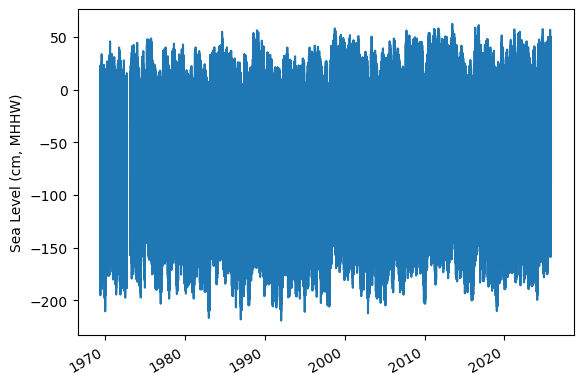

In [39]:
fig, ax = plt.subplots(sharex=True)
fig.autofmt_xdate()
ax.plot(rsl.time.values,rsl.sea_level_mhhw.T.values/10)

ax.set_ylabel(f'Sea Level (cm, {datumname})') #divide by 10 to convert to cm

glue("TS_full_fig",fig,display=False)


#### Identify epoch for the flood frequency analysis

Now, we'll calculate trend starting from the beginning of the tidal datum analysis period epoch to the last time processed. The  epoch information is given in the datums table. 

In [40]:
#get epoch start time from the epoch in the datumtable
epoch_times = datumtable[datumtable['Name'] == 'Epoch']['Value'].values[0]

#parse epoch times into start time
epoch_start = epoch_times.split(' ')[0]
epoch_start = datetime.datetime.strptime(epoch_start, '%d-%b-%Y')

# and for now, end time the processind end time
epoch_end = epoch_times.split(' ')[2]
epoch_end = datetime.datetime.strptime(epoch_end, '%d-%b-%Y')

# last date is rsl['last_rq_date'].values
data_end = rsl['time'].values[-1]
data_end = pd.to_datetime(data_end)

# start the data at year before epoch_start year on May 1st
data_start = pd.Timestamp(year=epoch_start.year-1, month=5, day=1)
data_start = pd.to_datetime(data_start)

# end the data at April 30th of the year of the last data request
data_end = pd.Timestamp(year=data_end.year, month=4, day=30)
data_end = pd.to_datetime(data_end)

hourly_data = rsl.sel(dict(time=slice(data_start, data_end)))
rsl.close()
hourly_data

glue("startDataDateTime",data_start.strftime('%Y-%m-%d'), display=False)
glue("endDataDateTime",data_end.strftime('%Y-%m-%d'), display=False)
glue("startEpochDateTime",epoch_start.strftime('%Y-%m-%d'), display=False)
glue("endEpochDateTime",epoch_end.strftime('%Y-%m-%d'), display=False)


and plot the hourly time series

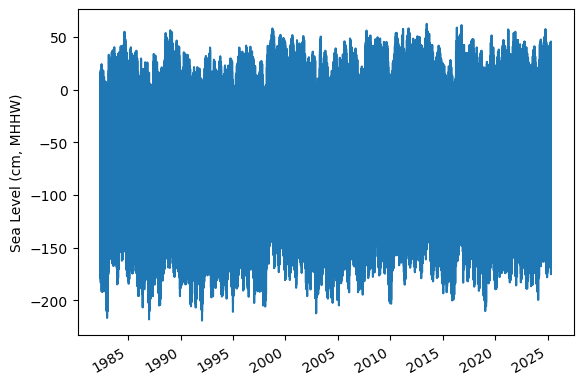

In [41]:
fig, ax = plt.subplots(sharex=True)
fig.autofmt_xdate()
ax.plot(hourly_data.time.values,hourly_data.sea_level_mhhw.T.values/10) #divide by 10 to convert to cm


ax.set_ylabel(f'Sea Level (cm, {datumname})')

glue("TS_epoch_fig",fig,display=False)


```{glue:figure} TS_epoch_fig
:name: "fig-TS_epoch"

Full time series at {glue:text}`station`,{glue:text}`country` tide gauge for the entire record from {glue:text}`startDataDateTime` to {glue:text}`endDataDateTime`. Note that the sea level is plotted in units of cm, relative to {glue:text}`datumname`.
```

### Assign a Threshold
The threshold used here to determine a flood event is 30 cm above MHHW.
```{note}
Change the threshold and see how things change!
```

In [42]:
threshold = 30 # in cm
glue("threshold",threshold,display=False)


## Calculate Flood Frequency
To analyze flood frequency, we will look for daily maximum sea levels for each day in our dataset, following {cite:t}`thompson_statistical_2019` and others. Then, we can group our data by year and month to visualize temporal patterns in daily SWL exceedance.   

```{glue:figure} histogram_fig
:name: "fig-histogram"
:figclass: margin

Histogram of daily maximum water levels at {glue:text}`station`,{glue:text}`country` tide gauge for the entire record from {glue:text}`startDataDateTime` to {glue:text}`endDataDateTime`, relative to {glue:text}`datumname`. The dashed red line indicates the chosen threshold of {glue:text}`threshold` cm.
```

```{margin}
Note this next code block may take a bit of time. Patience!
```

In [43]:
# Resample the hourly data to daily maximum sea level
SL_daily_max = hourly_data.resample(time='D').max()
static_vars = hourly_data[['station_name', 'station_country','station_country_code', 'datum','lat', 'lon','uhslc_id','gloss_id','ssc_id','last_rq_date']] 

SL_daily_max = SL_daily_max.assign(static_vars)
SL_daily_max

<xarray.Dataset> Size: 314kB
Dimensions:               (time: 15706, record_id: 1)
Coordinates:
  * record_id             (record_id) int64 8B 7
  * time                  (time) datetime64[ns] 126kB 1982-05-01 ... 2025-04-30
Data variables:
    sea_level             (time, record_id) float32 63kB 1.881e+03 ... 2.496e+03
    sea_level_mhhw        (time, record_id) float64 126kB -279.0 ... 336.0
    lat                   (record_id) float32 4B 7.33
    lon                   (record_id) float32 4B 134.5
    station_name          (record_id) <U7 28B 'Malakal'
    station_country       (record_id) <U5 20B 'Palau'
    station_country_code  (record_id) float32 4B 585.0
    uhslc_id              (record_id) int16 2B 7
    gloss_id              (record_id) float32 4B 120.0
    ssc_id                (record_id) |S4 4B b'mala'
    last_rq_date          (record_id) datetime64[ns] 8B 2018-12-31T22:59:59.9...
    datum                 float64 8B 2.16e+03
Attributes:
    title:                  UHSLC Fast Delivery Tide Gauge Data (hourly)
    ncei_template_version:  NCEI_NetCDF_TimeSeries_Orthogonal_Template_v2.0
    featureType:            timeSeries
    Conventions:            CF-1.6, ACDD-1.3
    date_created:           2025-12-18T14:36:30Z
    publisher_name:         University of Hawaii Sea Level Center (UHSLC)
    publisher_email:        philiprt@hawaii.edu, markm@soest.hawaii.edu
    publisher_url:          http://uhslc.soest.hawaii.edu
    summary:                The UHSLC assembles and distributes the Fast Deli...
    processing_level:       Fast Delivery (FD) data undergo a level 1 quality...
    acknowledgment:         The UHSLC Fast Delivery database is supported by ...

Text(0.5, 1.0, 'Sea Level Daily Maximum Time Series')

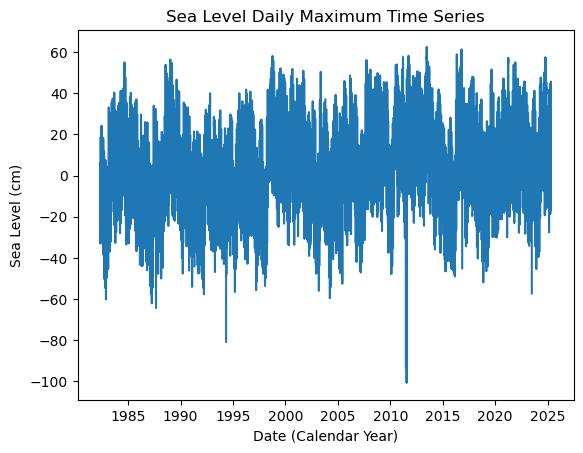

In [44]:
# make a new figure that is 15 x 5
fig, ax = plt.subplots(sharex=True)
plt.plot(SL_daily_max.time.values, SL_daily_max.sea_level_mhhw.values/10)
plt.xlabel('Date (Calendar Year)')
plt.ylabel('Sea Level (cm)')
plt.title('Sea Level Daily Maximum Time Series')

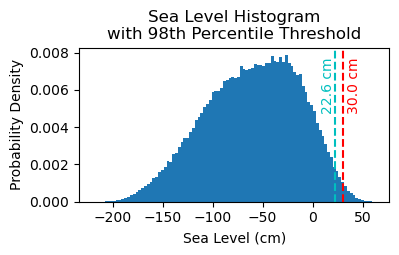

In [45]:
# Make a pdf of the data with 95th percentile threshold

sea_level_data_cm = hourly_data['sea_level_mhhw'].values/10 # convert to cm
#remove nans
sea_level_data_cm = sea_level_data_cm[~np.isnan(sea_level_data_cm)]

fig, ax = plt.subplots(figsize=(4,2))
ax.hist(sea_level_data_cm, bins=100, density=True, label='Sea Level Data')

#get 95th percentile
threshold98 = np.percentile(sea_level_data_cm, 98)

ax.axvline(threshold, color='r', linestyle='--', label='Threshold: {:.4f} cm'.format(threshold))
ax.axvline(threshold98, color='c', linestyle='--', label='Threshold: {:.4f} cm'.format(threshold98))

ax.set_xlabel('Sea Level (cm)')
ax.set_ylabel('Probability Density')
# make the title two lines
ax.set_title('Sea Level Histogram\nwith 98th Percentile Threshold')

# add label to dashed line
# get value of middle of y-axis for label placement
ymin, ymax = ax.get_ylim()
yrange = ymax - ymin
y_middle = ymin + 0.75*yrange

ax.text(threshold+4, y_middle, '{:.1f} cm'.format(threshold), rotation=90, va='center', ha='left', color='r')
ax.text(threshold98, y_middle, '{:.1f} cm'.format(threshold98), rotation=90, va='center', ha='right', color='c')

glue("histogram_fig", fig, display=False)

In [46]:
# Find all days where sea level exceeds the threshold
flood_days_df = SL_daily_max.to_dataframe().reset_index()

flood_days_df['year_storm'] = flood_days_df['time'].dt.year
flood_days_df.loc[flood_days_df['time'].dt.month > 4, 'year_storm'] = flood_days_df['time'].dt.year + 1

#filter flood hours
flood_days_df = flood_days_df[flood_days_df['sea_level_mhhw'] > threshold*10]

flood_days_per_year = flood_days_df.groupby('year_storm').size().reset_index(name='flood_days_count')

all_years = pd.DataFrame({'year_storm': range(flood_days_df['year_storm'].min(), flood_days_df['year_storm'].max() + 1)})

flood_days_per_year = all_years.merge(flood_days_per_year, on='year_storm', how='left').fillna(0)

flood_days_per_year['flood_days_count'] = flood_days_per_year['flood_days_count'].astype(int)


In [47]:
flood_hours_df = hourly_data.to_dataframe().reset_index()

flood_hours_df['year_storm'] = flood_hours_df['time'].dt.year
flood_hours_df.loc[flood_hours_df['time'].dt.month > 4, 'year_storm'] = flood_hours_df['time'].dt.year + 1

#filter flood hours
flood_hours_df = flood_hours_df[flood_hours_df['sea_level_mhhw'] > threshold*10]

flood_hours_per_year = flood_hours_df.groupby('year_storm').size().reset_index(name='flood_hours_count')

all_years = pd.DataFrame({'year_storm': range(flood_hours_df['year_storm'].min(), flood_hours_df['year_storm'].max() + 1)})

flood_hours_per_year = all_years.merge(flood_hours_per_year, on='year_storm', how='left').fillna(0)

flood_hours_per_year['flood_hours_count'] = flood_hours_per_year['flood_hours_count'].astype(int)

Let's have a quick look at the data in flood_hours_per_year:

In [48]:
# show the first few rows of the flood_days_per_year dataframe
flood_days_per_year.head()

,year_storm,flood_days_count
0,1983,1
1,1984,33
2,1985,40
3,1986,9
4,1987,0


## Plot Flood Frequency Counts
Now make a bar plot of the flood days (or hours) through time. We'll begin with a regular bar plot of the counts of flood days. Then we'll add a trend line. Then we'll plot it alongside the ENSO signal, for a visual inspection of any correlating signals. This plot follows {cite:t}center_for_operational_oceanographic_products_and_services_us_sea_2014.

### Simple bar plot
The time axis will be in storm years, and all the bars will be colored by the count of flooding days (more intense blues for more flood days).

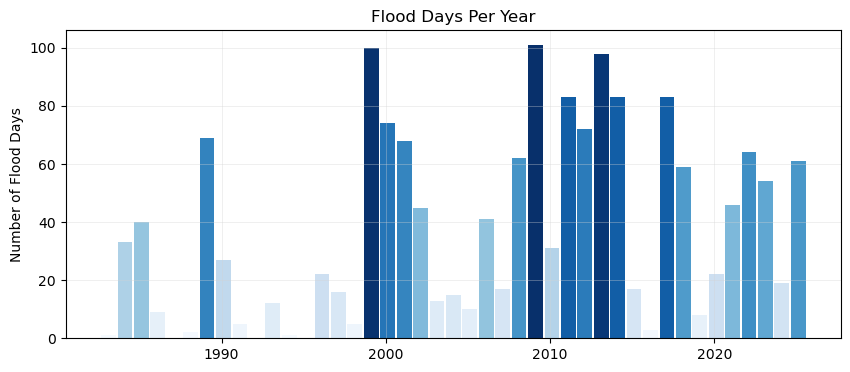

In [49]:
# Create two subplots sharing the same x-axis
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

def plot_flood_count_per_year(flood_count_per_year, ax, timescale='days', colors='Blues',bar_width=0.9,alpha=1,grid=True):
    x_values = flood_count_per_year['year_storm']  # Assuming this is already aligned to storm years
    x_values_offset = x_values - 4/12  # Shift x-values to align with the storm years
    if timescale == 'days':
        y_values = flood_count_per_year['flood_days_count']
        ylabelstring = 'Number of Flood Days'
        titlestring = 'Flood Days Per Year'
    elif timescale == 'hours':
        y_values = flood_count_per_year['flood_hours_count']
        ylabelstring = 'Number of Flood Hours'
        titlestring = 'Flood Hours Per Year'
    

    if isinstance(colors, str):
        flooding_colors = sns.color_palette(colors, as_cmap=True)
        norm = Normalize(vmin=min(y_values), vmax=max(y_values))

        colors = flooding_colors(norm(y_values))
    ax.bar(x_values_offset, y_values, width=bar_width, color=colors, align='edge', alpha=alpha)


    ax.set_ylabel(ylabelstring)
    ax.set_title(titlestring)
    if grid:
        ax.grid(color='lightgray', linestyle='-', linewidth=0.5, alpha=0.5)
    return x_values_offset.values, y_values.values, bar_width

x, y, bar_width = plot_flood_count_per_year(flood_days_per_year, ax)

### Simple bar plot with trend
Now, let's add a trend line to the plot, to see if there are any significant trends in flooding days since the start of our record.


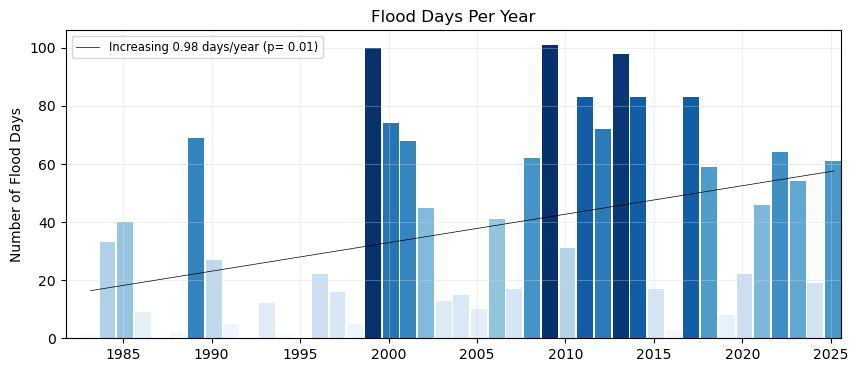

In [50]:
def get_trend_info(x, y, timescale='days'):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    trendCounts = intercept + slope * x
    if timescale == 'days':
        trendLabel = 'Increasing {:.2f} days/year (p= {:.2f})'.format(slope,p_value)
    elif timescale == 'hours':
        trendLabel = 'Increasing {:.2f} hours/year (p= {:.2f})'.format(slope,p_value)
    linestyleTrend = '-' if p_value < 0.05 else '--'
    return trendCounts, trendLabel, linestyleTrend, slope, p_value

def plot_trend(x, y, ax, timescale='days'):
    trendCounts, trendLabel, linestyleTrend, slope, p_value = get_trend_info(x, y, timescale=timescale)
    ax.plot(x, trendCounts, color='black', linestyle=linestyleTrend, label=trendLabel, linewidth=0.5)
    ax.legend(loc='upper left', fontsize='small')
    return slope, p_value, trendCounts

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
   
x, y, bar_width = plot_flood_count_per_year(flood_days_per_year, ax, timescale='days')
slope_days, p_value_days, trendDays = plot_trend(x+0.5, y, ax)

# # Set x-limits to ensure all bars are visible
ax.set_xlim(x.min() - bar_width, x.max() + bar_width);

glue("fig-threshold_counts", fig, display=False)




```{glue:figure} threshold_counts_days_fig
:name: "fig-threshold_counts"

Flood frequency counts above a threshold of {glue:text}`threshold:.3f` cm per year at {glue:text}`station`,{glue:text}`country` tide gauge from {glue:text}`startDataDateTime` to {glue:text}`endDataDateTime`. A trendline is added to the plot, showing a significant (p = {glue:text}`p_value_days:.2f`) increase in flood days per year ({glue:text}`days_per_year_trend:.2f` hours/year).
```

## Plot Flood Frequency Duration 
We'll do the same plot, but this time use our flooding hours data to examine the average duration of flooding events as defined by the threshold. Note that in this calculation these hours need not be continuous (and thus any changes in the scale of the flooding in terms of time-extent is not readily apparent, only the yearly summation.)

```{margin}
As with the previous plot, the colorbar uses a heatmap coloring (darker colors = more counts of hours or days per year). It is normalized by the minimum and maximum of the yearly flood count data.
```

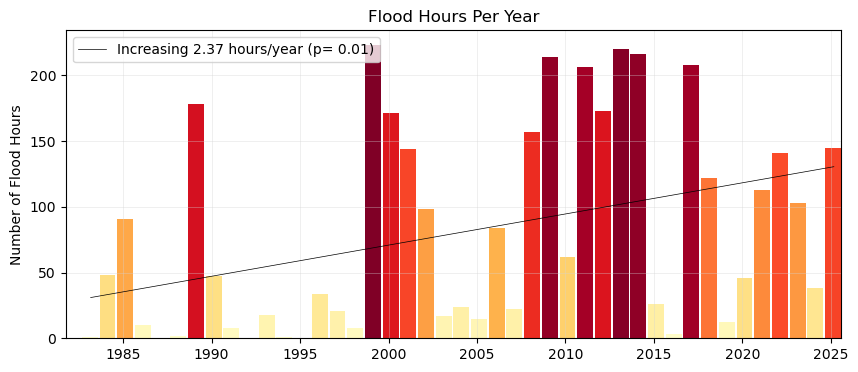

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
   
x, y, bar_width = plot_flood_count_per_year(flood_hours_per_year, ax, timescale='hours',colors='YlOrRd')
slope_hours, p_value_hours, trendHours = plot_trend(x+0.5, y, ax, timescale='hours')

# # Set x-limits to ensure all bars are visible
ax.set_xlim(x.min() - bar_width, x.max() + bar_width);

# # save the trendline values
glue("hours_per_year_trend",slope_hours,display=False)
glue("p_value_hours",p_value_hours,display=False)

# Adding the legend
ax.legend(loc='upper left')

glue("duration_fig", fig, display=False)

```{glue:figure} duration_fig
:name: "fig-duration"

Average flood duration in hours above a threshold of {glue:text}`threshold:.0f` cm per year at {glue:text}`station`,{glue:text}`country` tide gauge from {glue:text}`startDataDateTime` to {glue:text}`endDataDateTime`. A trendline is added to the plot, showing a significant (p = {glue:text}`p_value_hours:.2f`) increase in flood days per year ({glue:text}`hours_per_year_trend:.2f` hours/year).
```

## Add the ENSO signal to bar plots

First we'll download our ONI data

In [52]:
# add nino
p_data = 'https://psl.noaa.gov/data/correlation/oni.data'
oni = download_oni_index(p_data)
enso_events = detect_enso_events(oni)

We'll turn this into yearly data by looking at the dominant enso mode for that storm year.

In [53]:
#turn oni events into yearly dataframe
def get_dominant_enso(series):
    el_nino_count = (series == 'El Nino').sum()
    la_nina_count = (series == 'La Nina').sum()
    
    if el_nino_count > la_nina_count:
        return 'El Nino'
    elif la_nina_count > el_nino_count:
        return 'La Nina'
    else:
        return 'Neutral'

enso_yearly = enso_events.groupby('year_storm')['ONI Mode'].agg(get_dominant_enso).to_frame(name='ONI Mode')
enso_yearly['ONI'] = enso_events.groupby('year_storm')['ONI'].mean()
enso_yearly

,ONI Mode,ONI
year_storm,,
1950,Neutral,-0.337500
1951,El Nino,0.670833
1952,El Nino,0.237500
1953,El Nino,0.586667
1954,La Nina,-0.697500
...,...,...
2021,La Nina,-0.761667
2022,La Nina,-0.700833
2023,El Nino,1.330000


In [54]:
# add enso events to flood_days_per_year
flood_days_per_year = flood_days_per_year.merge(enso_yearly, on='year_storm', how='left')
flood_days_per_year.head()

,year_storm,flood_days_count,ONI Mode,ONI
0,1983,1,El Nino,-0.246667
1,1984,33,La Nina,-0.643333
2,1985,40,La Nina,-0.434167
3,1986,9,El Nino,0.745000
4,1987,0,El Nino,1.005833


### Plot the ONI signal through time
We'll color it by El Nino/La Nina



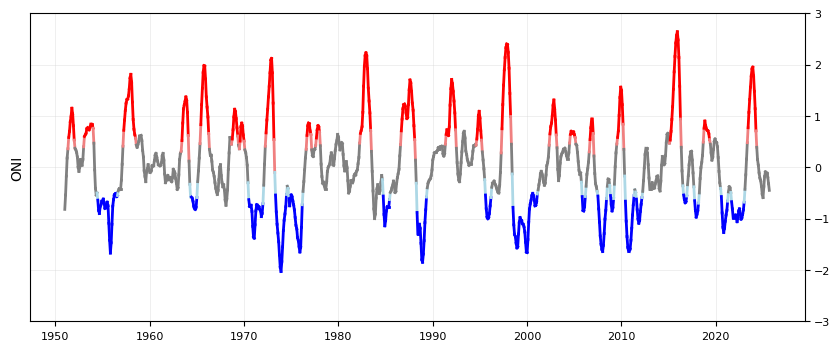

In [55]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

def plot_ONI_segments(enso_events, ax):
    """
    Plots the ONI index as line segments colored by ENSO mode.
    
    Parameters:
    enso_events (pd.DataFrame): DataFrame containing 'ONI', 'ONI Mode', and 'year_float' columns.
    ax (matplotlib.axes.Axes): The axes to plot on.
    """

    enso_events['year_float'] = enso_events.index.year + (enso_events.index.month - 1) / 12
    
    ax.set_ylabel('ONI')
    ax.grid(color='lightgray', linestyle='-', linewidth=0.5, alpha=0.5)
    ax.set_ylim(-3, 3)
    
    # Plot line segments with colors based on BOTH endpoints' ENSO modes
    for i in range(len(enso_events) - 1):
        x_segment = enso_events['year_float'].iloc[i:i+2]
        y_segment = enso_events['ONI'].iloc[i:i+2]
        mode_start = enso_events['ONI Mode'].iloc[i]
        mode_end = enso_events['ONI Mode'].iloc[i+1]
        
        # Only color the segment if BOTH points have the same mode
        if mode_start == mode_end:
            if mode_start == 'La Nina':
                color = 'blue'
            elif mode_start == 'El Nino':
                color = 'red'
            else:
                color = 'gray'
        elif mode_start != mode_end:
            if mode_start == 'La Nina' and mode_end == 'Neutral':
                color = 'lightblue'  # Transition from La Nina to Neutral
            elif mode_start == 'Neutral' and mode_end == 'La Nina':
                color = 'lightblue'  # Transition from Neutral to La Nina
            elif mode_start == 'El Nino' and mode_end == 'Neutral':
                color = 'lightcoral'  # Transition from El Nino to Neutral
            elif mode_start == 'Neutral' and mode_end == 'El Nino':
                color = 'lightcoral'  # Transition from Neutral to El Nino
            else:
            # Transition segment - use gray
                color = 'gray'

        ax.plot(x_segment, y_segment, color=color, linewidth=2)


    # put y-axis labels on the right side
    ax.yaxis.tick_right()

    # set font size for tick labels
    ax.tick_params(axis='both', which='major', labelsize=8)

plot_ONI_segments(enso_events, ax)

### Plot combined flood days with ENSO signal 
Now we'll combine our previous plots into one.
<!-- The flood frequency counts are defined as the number of time periods that exceed a given threshold within a year. This plot follows {cite:t}`center_for_operational_oceanographic_products_and_services_us_sea_2014`. -->

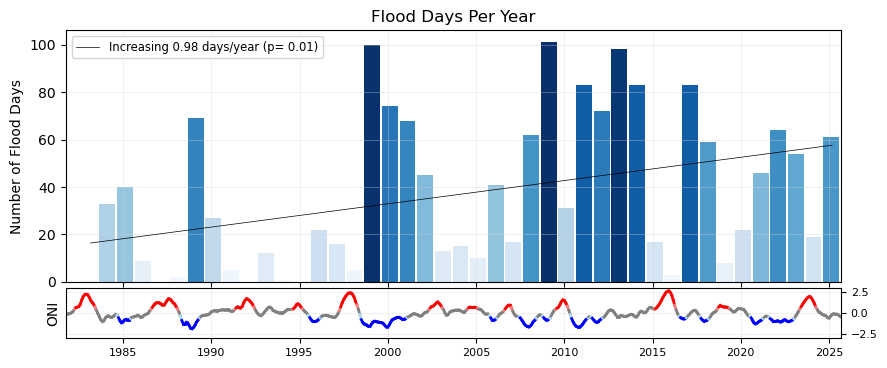

In [56]:
# Create two subplots sharing the same x-axis
fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(10, 4),  sharex=True, gridspec_kw={"height_ratios": [5, 1],"hspace": 0.04, }
)

x, y, bar_width = plot_flood_count_per_year(flood_days_per_year, ax1)
slope_days, p_value_days, trendDays= plot_trend(x+0.5, y, ax1);
plot_ONI_segments(enso_events, ax2)

ax1.set_xlim(x.min()-bar_width, x.max()+1);

# # # save the trendline values
glue("day_per_year_trend",slope_days,display=False);
glue("p_value_days",p_value_days,display=False);

# save the figure
glue("fig-threshold_counts_enso", fig, display=False)

# save to output directory
fig.savefig(output_dir / "SL_FloodFrequency_threshold_counts_days.png", dpi=300, bbox_inches='tight')



```{glue:figure} threshold_counts_days_fig_enso
:name: "fig-threshold_counts_enso"

Flood frequency counts above a threshold of {glue:text}`threshold:.0f` cm per year at {glue:text}`station`,{glue:text}`country` tide gauge from {glue:text}`startDataDateTime` to {glue:text}`endDataDateTime`. The bottom subplot shows the ONI index for the same time period, with red corresponding to El Nino conditions (ONI>0.5) and blue corresponding to La Nina conditions (ONI<-0.5). A trendline is added to the plot, showing a significant (p = {glue:text}`p_value_days:.2f`) increase in flood days per year ({glue:text}`days_per_year_trend:.2f` days/year).
```

## Create a Table

Next we'll calculate some summary statistics over the POR at the tide station/s, for both Frequency and Duration.

We will include the trendline statistics from our previous plots.


In [57]:
# Calculate the total number of days/hours exceeding the threshold
total_flood_days = flood_days_per_year['flood_days_count'].sum()
total_flood_hours = flood_hours_per_year['flood_hours_count'].sum()

# Calculate the average number of flood days and hours per year
average_flood_days_per_year = total_flood_days / len(flood_days_per_year)
average_flood_hours_per_year = flood_hours_per_year['flood_hours_count'].mean()

# Find the maximum number of flood days in a single year
max_flood_days = flood_days_per_year['flood_days_count'].max()
max_flood_days_year = flood_days_per_year.loc[flood_days_per_year['flood_days_count'].idxmax(), 'year_storm']

# Find the maximum number of flood hours in a single year
max_flood_hours = flood_hours_per_year['flood_hours_count'].max()
max_flood_hours_year = flood_hours_per_year.loc[flood_hours_per_year['flood_hours_count'].idxmax(), 'year_storm']

# calculate the absolute percent change over the entire period using the first and last part of the trend
percent_change_days = (trendDays[-1]-trendDays[0])/trendDays[0]*100
percent_change_hours = (trendHours[-1]-trendHours[0])/trendHours[0]*100

Now we'll generate a table with this information, which will be saved as a .csv in the output directory specified at the top of this notebook.

In [58]:
# Create a dataframe for statistics
summary_stats = [
    ('Total Flood Days', int(total_flood_days)),
    ('Average Flood Days per Year', int(average_flood_days_per_year)),
    ('Max Flood Days in a Single Year', int(max_flood_days)),
    ('Year of Max Flood Days', int(max_flood_days_year)),
    ('Total Flood Hours', int(total_flood_hours)),
    ('Average Flood Hours per Year', int(average_flood_hours_per_year)),
    ('Max Flood Hours in a Single Year', int(max_flood_hours)),
    ('Year of Max Flood Hours', int(max_flood_hours_year)),
    ('Percent Change in Flood Days', int(percent_change_days)),
    ('Percent Change in Flood Hours', int(percent_change_hours)),
    ('Trend in Flood Days (days/year)', round(slope_days, 2)),
    ('P-value for Flood Days Trend', round(p_value_days, 2)),
    ('Trend in Flood Hours (hours/year)', round(slope_hours, 2)),
    ('P-value for Flood Hours Trend', round(p_value_hours, 2))
]

# Convert the list of tuples to a pandas DataFrame
summary_stats_df = pd.DataFrame(summary_stats, columns=['Statistic', 'Value'])

# Display the DataFrame
summary_stats_df

,Statistic,Value
0,Total Flood Days,1591.00
1,Average Flood Days per Year,37.00
2,Max Flood Days in a Single Year,101.00
3,Year of Max Flood Days,2009.00
4,Total Flood Hours,3470.00
5,Average Flood Hours per Year,80.00
6,Max Flood Hours in a Single Year,223.00
7,Year of Max Flood Hours,1999.00
8,Percent Change in Flood Days,251.00
9,Percent Change in Flood Hours,321.00


## Create a sub-annual table
Here we'll turn our 'flooding days' into a dataframe to look at monthly changes through time.

In [59]:
import calendar
# Make a dataframe with years as rows and months as columns
df = SL_daily_max.to_dataframe().reset_index()
df['flood_day'] = df['sea_level_mhhw'] > threshold*10

# keep only the flood day and time columns
df = df[['time', 'flood_day']]

df['year'] = df['time'].dt.year
df['month'] = df['time'].dt.month

# adjust for storm year
df.loc[df['month'] > 4, 'year'] = df.loc[df['month'] > 4, 'year'] + 1

# drop original time column
df = df.drop(columns=['time'])

# sum the number of flood days in each month for each storm year
df = df.groupby(['year', 'month']).sum()

# pivot the table
df = df.pivot_table(index='year', columns='month', values='flood_day')

# remove first and last rows (partial years)
# df = df.iloc[1:-1]

# rename year to Storm Year
df.index.name = 'Storm Year'

#define reordered months (for storm year, May to April)
month_order = [5,6,7,8,9,10,11,12,1,2,3,4]
month_names = [calendar.month_abbr[i] for i in month_order]
# rename months to month names
df = df[month_order]
df.columns = month_names

# add a column for the total number of flood days in each year
df['Annual'] = df.sum(axis=1)



# add a row for the total number of flood days in each month, normalized the total flood days (last row, last column)
df.loc['Monthly Total (%)'] = df.sum()
df.loc['Monthly Total (%)'] = 100*df.loc['Monthly Total (%)']/df.loc['Monthly Total (%)', 'Annual']

# station_name = SL_daily_max['station_name'] +', ' + SL_daily_max['station_country']

tableTitle = station_name + ': Days Exceeding ' + str(threshold) + ' cm above MHHW'
# Apply background gradient and add a title with larger text
styled_df = df.style.background_gradient(
    cmap='Purples', axis=None, subset=(df.index[:-1], df.columns[:-1])
).format("{:.0f}").background_gradient(
    cmap='Grays', axis=None, subset=(df.index[-1], df.columns[:-1])
).format("{:.0f}").set_caption(tableTitle).set_table_styles([
    {
        'selector': 'caption',
        'props': [('font-size', '16px'), ('margin-bottom', '10px')]
    }
])

styled_df


,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Jan,Feb,Mar,Apr,Annual
Storm Year,,,,,,,,,,,,,
1983,0,0,0,0,0,0,0,0,0,1,0,0,1
1984,1,5,5,4,3,2,1,0,2,3,1,6,33
1985,5,1,4,9,6,3,4,0,0,0,3,5,40
1986,3,2,0,0,2,2,0,0,0,0,0,0,9
1987,0,0,0,0,0,0,0,0,0,0,0,0,0
1988,0,1,0,1,0,0,0,0,0,0,0,0,2
1989,0,0,4,8,6,7,4,3,17,7,7,6,69
1990,4,0,2,6,5,4,4,0,0,0,0,2,27
1991,3,1,0,0,1,0,0,0,0,0,0,0,5


We can also make this in plot form (instead of a styled dataframe).

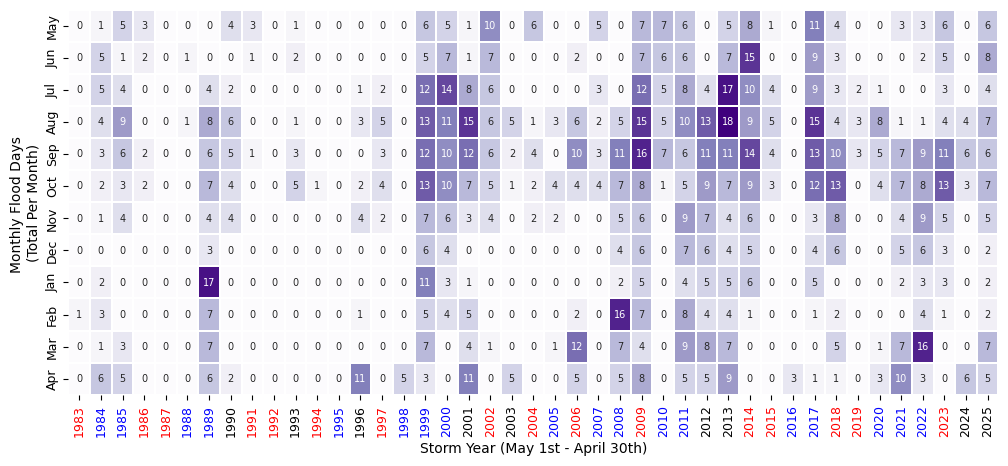

In [60]:
fig, ax = plt.subplots(figsize=(12, 5))
# heatmap of monthly flood days 
sns.heatmap(df.iloc[:-1, :-1].T, cmap="Purples", annot=True, fmt=".0f", linewidths=0.2, 
            ax=ax,cbar=False, annot_kws={"size": 7})
ax.set_ylabel("Monthly Flood Days \n(Total Per Month)")
ax.set_xlabel("Storm Year (May 1st - April 30th)")
ax.tick_params(axis='y', labelsize=9)
ax.tick_params(axis='x', labelsize=9)

# Create a mapping from year to ONI mode
year_to_mode = flood_days_per_year.set_index('year_storm')['ONI Mode']
color_map = {'El Nino': 'red', 'La Nina': 'blue', 'Neutral': 'black'}

# Set the color for each x-tick label based on the ONI mode for that year
for label in ax.get_xticklabels():
    year = int(label.get_text())
    mode = year_to_mode.get(year, 'Neutral')  # Default to 'Neutral' if not found
    label.set_color(color_map.get(mode, 'black')) # Default to 'black'

## Plot Monthly Frequency Bar Plot
We can also make this information into a bar plot to compare the monthly contribution visually. This code is made so the bar plot can be plotted in either vertical or horizontal bars. This will come up later when we combine our tables and plots into one summary figure.

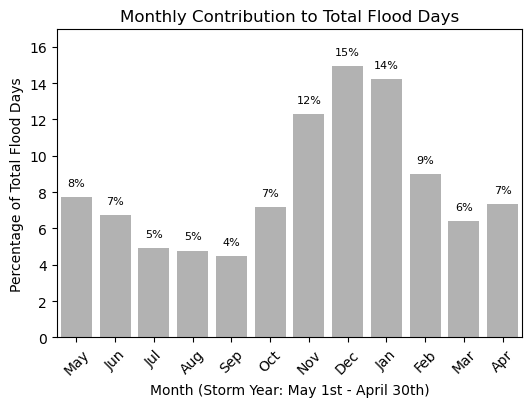

In [61]:
# # bar plot of monthly totals 
fig,ax = plt.subplots(figsize=(6, 4))

def plot_monthly_contribution(df, ax, direction='vertical'):
    
    if direction == 'horizontal':
        ax.barh(range(1, 13), df.iloc[-1, :-1][::-1], color="gray", alpha=0.6, label="Monthly Contribution \n (% Total Flood Days)")
        ax.set_yticks(range(1, 13))
        ax.set_ylim(0.5, 12.5)
        ax.set_yticklabels(month_names[::-1])
        # add labels and title
        ax.set_ylabel('Month (Storm Year: May 1st - April 30th)')
        ax.set_xlabel('Percentage of Total Flood Days')
                # adjust layout to avoid clipping of labels
        ax.set_xlim(0, df.iloc[-1, :-1][::-1].max() + 2)
        # annotate the percentage values on top of the bars
        for i, value in enumerate(df.iloc[-1, :-1][::-1]):
            ax.text( value + 0.5,i + 1, f'{value:.0f}%', ha='left', va='center', fontsize=8)
    elif direction == 'vertical':
        ax.bar(range(1, 13), df.iloc[-1, :-1][::-1], color="gray", alpha=0.6, label="Monthly Contribution \n (% Total Flood Days)")
        # ensure each month is labeled
        ax.set_xticks(range(1, 13))
        ax.set_xlim(0.5, 12.5)
        # relabel x-axis with month names
        ax.set_xticklabels(month_names, rotation=45)

        # add labels and title
        ax.set_xlabel('Month (Storm Year: May 1st - April 30th)')
        ax.set_ylabel('Percentage of Total Flood Days')
        # adjust layout to avoid clipping of labels
        ax.set_ylim(0, df.iloc[-1, :-1][::-1].max() + 2)
        # annotate the percentage values on top of the bars
        for i, value in enumerate(df.iloc[-1, :-1][::-1]):
            ax.text(i + 1, value + 0.5, f'{value:.0f}%', ha='center', va='bottom', fontsize=8)


    ax.set_title('Monthly Contribution to Total Flood Days')



plot_monthly_contribution(df, ax, direction='vertical')

We can also make a nice table for printed reports.

In [62]:
#make a pretty pdf of the table with great_tables
from great_tables import GT,html

dfGT = df.copy()
dfGT['Storm Year'] = df.index

# put the year column first
cols = dfGT.columns.tolist()
cols = cols[-1:] + cols[:-1]
dfGT = dfGT[cols]
dfGT.reset_index(drop=True, inplace=True)


# Create a GreatTable object
table = (GT(dfGT)
.fmt_number(columns=calendar.month_abbr[1:13], decimals=0)
.fmt_number(columns=['Annual'], decimals=0)
.tab_header(title = 'Days Exceeding 30 cm above MHHW', subtitle = station_name)
.data_color(domain = [0,20],
            columns=calendar.month_abbr[1:13],
            rows = list(range(len(dfGT)-1)),
            palette=["white", "lightblue"])
.data_color(domain = [0,20],
            columns=calendar.month_abbr[1:13],
            rows = [-1],
            palette=["white", "purple"])
.opt_table_outline(style='solid', width='3px', color='white')
)

# save table as png
tableName = station_name + '_flood_days_intra_annual.png'
savePath = os.path.join(output_dir, tableName)

# set size of table

# replace any commas or spaces with underscores
# savePath = savePath.replace(' ', '_')
table.save(savePath)

# Load Image
from IPython.display import Image
imgTable = Image(filename=savePath)

# Glue the image with a name
glue("imgTable", imgTable, display=False)


In [63]:
# Define the decades for analysis
decades = [(1983, 1993), (1993, 2003), (2003, 2013), (2013, 2023)]

# Initialize lists to store results
total_flood_days_list = []
average_flood_days_per_year_list = []
percent_increase_days_per_year_list = [0]  # First decade has no previous data for comparison

# Calculate statistics for each decade
for i, (start_year, end_year) in enumerate(decades):
    # Filter the dataframe for the current decade
    flood_days_decade = flood_days_per_year[(flood_days_per_year['year_storm'] >= start_year) & (flood_days_per_year['year_storm'] <= end_year)]
    sum_flood_days_decade = flood_days_decade['flood_days_count'].sum()
    avg_flood_days_decade = sum_flood_days_decade / len(flood_days_decade)
    
    # Append results to lists
    total_flood_days_list.append(sum_flood_days_decade)
    average_flood_days_per_year_list.append(np.round(avg_flood_days_decade,0))
    
    # Calculate percent increase for subsequent decades
    if i > 0:
        prev_avg_flood_days = average_flood_days_per_year_list[0]
        percent_increase = np.round((avg_flood_days_decade - prev_avg_flood_days) / prev_avg_flood_days * 100, 1)
        percent_increase_days_per_year_list.append(percent_increase)

# Create a dataframe for decadal statistics
decadal_stats = pd.DataFrame({
    'decade': ['1983-1993', '1993-2003', '2003-2013', '2013-2023'],
    'total_flood_days': total_flood_days_list,
    'average_flood_days_per_year': average_flood_days_per_year_list,
    'percent_increase_days_per_year': percent_increase_days_per_year_list
})

decadal_stats


,decade,total_flood_days,average_flood_days_per_year,percent_increase_days_per_year
0,1983-1993,198,18.0,0.0
1,1993-2003,356,32.0,79.8
2,2003-2013,543,49.0,174.2
3,2013-2023,537,49.0,171.2


## Join plots and tables

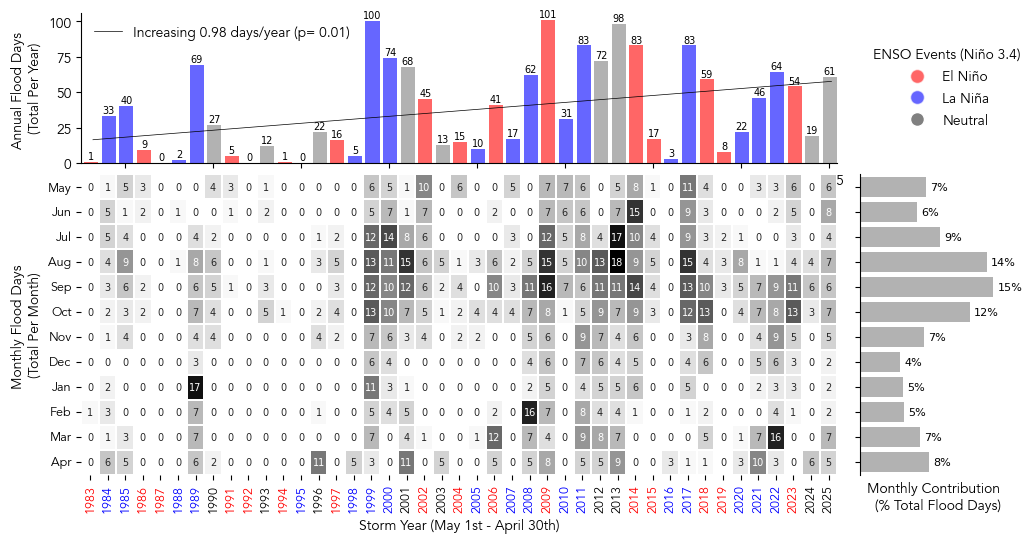

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


# Create a figure and shared axis layout
fig, axs = plt.subplots(2,2,figsize=(12,6), gridspec_kw={"height_ratios": [1, 2], "hspace": 0.05, "width_ratios":[5,1], "wspace": 0.05})

# put stuff in the figure

# heatmap of monthly flood days on the bottom left axis
sns.heatmap(df.iloc[:-1, :-1].T, cmap="Grays", annot=True, fmt=".0f", linewidths=0.2, 
            ax=axs[1,0],cbar=False, annot_kws={"size": 7})
axs[1,0].set_ylabel("Monthly Flood Days \n(Total Per Month)")
axs[1,0].set_xlabel("Storm Year (May 1st - April 30th)")
axs[1,0].tick_params(axis='y', labelsize=9)
axs[1,0].tick_params(axis='x', labelsize=9)

# Set the color for each x-tick label based on the ONI mode for that year
for label in axs[1,0].get_xticklabels():
    year = int(label.get_text())
    mode = year_to_mode.get(year, 'Neutral')  # Default to 'Neutral' if not found
    label.set_color(color_map.get(mode, 'black')) # Default to 'black'


# yearly totals on the top left axis
ax2 = axs[0,0] 

# color by enso_event
enso_colors = ['red' if val == 'El Nino' else 'blue' if val == 'La Nina' else 'gray' for val in flood_days_per_year['ONI Mode']]
x, y, bar_width = plot_flood_count_per_year(flood_days_per_year, ax2, timescale='days', 
                                            colors=enso_colors,grid=False,alpha=0.6,bar_width=0.8)

# bars = ax2.bar(df.index[0:-1], df["Annual"][0:-1], color=enso_colors, alpha=0.6)
ax2.set_xlim(df.index[0]-0.5, df.index[-2]+0.5)

# annotate bars with their values
for xi, yi in zip(x, y):
    ax2.text(xi + bar_width / 2, yi + 0.5, str(int(yi)), ha='center', va='bottom', fontsize=7, color='black')

# remove top and right boundaries
for spine in ['top', 'right']:
    ax2.spines[spine].set_visible(False)
ax2.set_ylabel("Annual Flood Days \n(Total Per Year)")
ax2.set_title("")
ax2.grid(visible=False)

# add trendline to the yearly totals on ax2
slope_days, p_value_days, trendDays = plot_trend(x+0.5, y, ax2)
legend = ax2.legend(loc='upper left', fontsize='small', frameon=False, prop={'family': 'Avenir'})


# # bar plot of monthly totals on the bottom right axis
ax3 = axs[1,1]
barMonth = plot_monthly_contribution(df, ax3, direction='horizontal')
ax3.set_yticklabels([])
ax3.set_ylabel("")
ax3.set_title("")
# #remove x-axis ticks and labels
ax3.set_xticks([])
ax3.set_xlabel("Monthly Contribution \n (% Total Flood Days)")

# #remove top and right boundaries
for spine in ax3.spines.values():
    spine.set_visible(False)

ax3.spines['left'].set_visible(True)


# add a legend in the remaining axis (top right)
# ax[0,1] defines the coloring we used in the yearly total bar plot
ax4 = axs[0,1]
ax4.axis('off')
# create a legend for the oni_colors
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label='El Niño', markerfacecolor='red', markersize=10, alpha=0.6),
                   plt.Line2D([0], [0], marker='o', color='w', label='La Niña', markerfacecolor='blue', markersize=10, alpha=0.6),
                   plt.Line2D([0], [0], marker='o', color='w', label='Neutral', markerfacecolor='gray', markersize=10)]
legend = ax4.legend(handles=legend_elements, loc='center left', title='ENSO Events (Niño 3.4)', frameon=False)


legend_title = legend.get_title()
legend_title.set_fontsize('10')
legend_title.set_fontname('Avenir')
legend_texts = legend.get_texts()
for text in legend_texts:
    text.set_fontname('Avenir')
    text.set_fontsize('10')


# set all fonts in the figure to Avenir
# Iterate over all axes in the figure
for ax in axs.flat:
    # Change font for title, axis labels, and tick labels
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontname('Avenir')


# #save the figure
fig.savefig(output_dir / 'SL_FloodFrequency_threshold_counts_heatmap.png', bbox_inches='tight')
plt.savefig(op.join(path_figs, 'F11_Minor_flood_matrix.png'), dpi=300, bbox_inches='tight')


```{glue:figure} imgTable
:name: "imgTable"
:scale: 40%
Monthly and Annual tally of flooding days at {glue:text}`station`, {glue:text}`country` .
```

## Citations

```{bibliography}
:style: alpha
:filter: docname in docnames
```